<a href="https://colab.research.google.com/github/Chaksome/Machine-Learning-Mnist/blob/main/myMPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%%time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt

CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 1.43 ms


In [2]:
batch_size = 100
num_classes = 10
epochs = 10

In [3]:
def preprocess_images(x):
  n_data, dim0, dim1 = tuple(x.shape)
  n_sites = dim0 * dim1
  xx = x.reshape((n_data, n_sites)) / 255
  x = x / 255.0
  for k in range(len(x)):
      xx[k] = np.concatenate([np.diagonal(x[k][::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-x[k].shape[0], x[k].shape[0])])      #zigzag：相比于简单的一维化，拉链式的降为更能保留图像原本信息
  
  xxx = tf.cast(tf.math.greater(xx, 0.5), dtype=tf.int32)
  y = tf.keras.utils.to_categorical(xxx, 2)
#第一步：将原始数据变为矢量直积形态，此处维度取2，转化方法为x->[x,1-x]  
  for k in range(len(xx)):
      for i in range(len(xx[0])):
#       y[k][i] = [np.cos(x[k][i]*np.pi/2)**2, np.sin(x[k][i]*np.pi/2)**2]
        y[k][i] = [xx[k][i], 1-xx[k][i]]     
#       if x[k][i] <= 0.5 :
#          y[k][i] = [1, 0]
#       else:
#          y[k][i] = [0, 1]
  return y


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
from scipy.ndimage import interpolation
#第二步：对图像进行deskew

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] 
    totalImage = np.sum(image) 
    m0 = np.sum(c0*image)/totalImage 
    m1 = np.sum(c1*image)/totalImage 
    m00 = np.sum((c0-m0)**2*image)/totalImage 
    m11 = np.sum((c1-m1)**2*image)/totalImage 
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage 
    mu_vector = np.array([m0,m1]) 
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) 
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)#求图像的矩，根据此来进行图像旋转
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)))
    return np.array(currents)

x_train = deskewAll(x_train)
x_test = deskewAll(x_test)
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
# convert images to supported format
x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

11501568/11490434 [==============================] - 0s 0us/step


Epoch 1/30
Cause: Unable to locate the source code of <bound method MPSLayer.call of <__main__.MPSLayer object at 0x7f80ecfc0e90>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <bound method MPSLayer.call of <__main__.MPSLayer object at 0x7f80ecfc0e90>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original erro

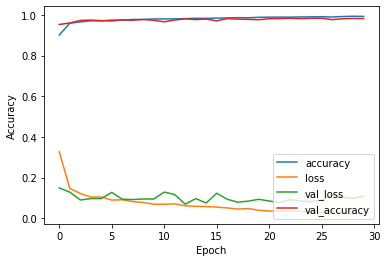

Test loss: 0.10829925537109375
Test accuracy: 0.9815000295639038
CPU times: user 2h 19min 8s, sys: 2min 56s, total: 2h 22min 4s
Wall time: 1h 15min 35s


In [6]:
%%time
d_bond =4#  MPS辅助空间维数
#第三步：搭建MPS张量网络
class MPSLayer(layers.Layer):

  def __init__(self, n_sites, d_bond, n_output, dtype=tf.float32):
    super(MPSLayer, self).__init__()
    if n_sites % 2:
        raise NotImplementedError("Number of sites should be even but is "
                                  "{}.".format(n_sites))
    #分别对左矢、核、右矢进行初始化
    self.n_half = n_sites // 2
    self.left = tf.Variable(self._initializer(self.n_half, 2, d_bond),
                            dtype=dtype, trainable=True)
    self.right = tf.Variable(self._initializer(self.n_half, 2, d_bond),
                             dtype=dtype, trainable=True)
    self.middle = tf.Variable(self._initializer(n_output, 1, d_bond)[0],
                              dtype=dtype, trainable=True)

  @staticmethod#初始化权重
  def _initializer(n_sites, d_phys, d_bond):
    w = np.stack(d_phys * n_sites * [np.eye(d_bond)])
    w = w.reshape((d_phys, n_sites, d_bond, d_bond))
    return w + np.random.normal(0, 1e-2, size=w.shape)

  def call(self, inputs):
    left = tf.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])#左半部分连接张量与数据
    right = tf.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])#右半部分连接张量与数据
    left = self.reduction(left)#对左半边进行张量缩并
    right = self.reduction(right)#对右半边进行张量缩并
    f = tf.einsum("bij,cjk,bki->bc", left, self.middle, right)#三者求内积得到函数求误差函数
    return f

  @staticmethod
  def reduction(tensor):#定义缩并函数
    size = int(tensor.shape[0])
    while size > 1:
      half_size = size // 2
      nice_size = 2 * half_size
      leftover = tensor[nice_size:]
      tensor = tf.matmul(tensor[0:nice_size:2], tensor[1:nice_size:2])
      tensor = tf.concat([tensor, leftover], axis=0)
      size = half_size + int(size % 2 == 1)
    return tensor[0]


# 定义模型
n_sites = x_train.shape[1]
model = Sequential()
model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))#mps层
model.add(layers.Softmax())


# Compile and run
model.compile(optimizer='Adam',loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)#学习率
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test),callbacks=[annealer])
score = model.evaluate(x_test, y_test, verbose=0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Text(0, 0.5, 'Accuracy')

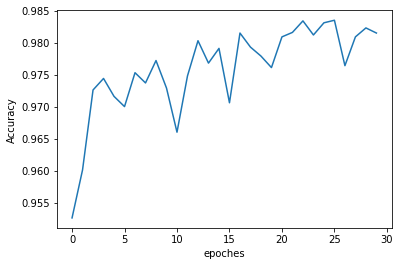

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoches')
plt.ylabel('Accuracy')

Epoch 1/30
Cause: Unable to locate the source code of <bound method MPSLayer.call of <__main__.MPSLayer object at 0x7f80f795ea90>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <bound method MPSLayer.call of <__main__.MPSLayer object at 0x7f80f795ea90>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original erro

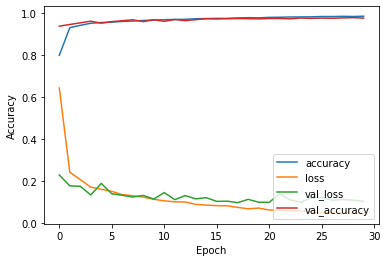

Test loss: 0.10348210483789444
Test accuracy: 0.9761999845504761
CPU times: user 2h 17min 59s, sys: 2min 10s, total: 2h 20min 10s
Wall time: 1h 14min 35s


In [25]:
%%time
d_bond =6#  MPS辅助空间维数
class MPSLayer(layers.Layer):

  def __init__(self, n_sites, d_bond, n_output, dtype=tf.float32):
    super(MPSLayer, self).__init__()
    if n_sites % 2:
        raise NotImplementedError("Number of sites should be even but is "
                                  "{}.".format(n_sites))
    #分别对左矢、核、右矢进行初始化
    self.n_half = n_sites // 2
    self.left = tf.Variable(self._initializer(self.n_half, 2, d_bond),
                            dtype=dtype, trainable=True)
    self.right = tf.Variable(self._initializer(self.n_half, 2, d_bond),
                             dtype=dtype, trainable=True)
    self.middle = tf.Variable(self._initializer(n_output, 1, d_bond)[0],
                              dtype=dtype, trainable=True)

  @staticmethod#初始化权重
  def _initializer(n_sites, d_phys, d_bond):
    w = np.stack(d_phys * n_sites * [np.eye(d_bond)])
    w = w.reshape((d_phys, n_sites, d_bond, d_bond))
    return w + np.random.normal(0, 1e-2, size=w.shape)

  def call(self, inputs):
    left = tf.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])#左半部分连接张量与数据
    right = tf.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])#右半部分连接张量与数据
    left = self.reduction(left)#对左半边进行张量缩并
    right = self.reduction(right)#对右半边进行张量缩并
    f = tf.einsum("bij,cjk,bki->bc", left, self.middle, right)#三者求内积得到函数求误差函数
    return f

  @staticmethod
  def reduction(tensor):#定义缩并函数
    size = int(tensor.shape[0])
    while size > 1:
      half_size = size // 2
      nice_size = 2 * half_size
      leftover = tensor[nice_size:]
      tensor = tf.matmul(tensor[0:nice_size:2], tensor[1:nice_size:2])
      tensor = tf.concat([tensor, leftover], axis=0)
      size = half_size + int(size % 2 == 1)
    return tensor[0]


# 定义模型
n_sites = x_train.shape[1]
model = Sequential()
model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))#mps层
model.add(layers.Softmax())


# Compile and run
model.compile(optimizer='Adam',loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)#学习率
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test),callbacks=[annealer])
score = model.evaluate(x_test, y_test, verbose=0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

print('Test loss:', score[0])
print('Test accuracy:', score[1])

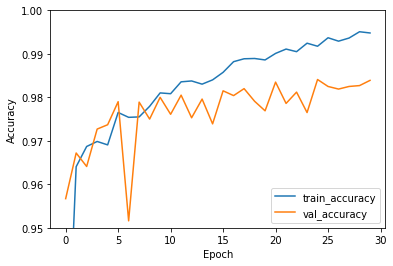

In [21]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')
plt.show()